### Miniapp License

This notebook is licensed under the [MIT License](https://opensource.org/licenses/MIT).


### Adam Lawrence | adamrl3
#### CS555-Miniapp

# Taylor–Hood elements for Stokes

This mini‑app demonstrates a FEM implementation of the stationary incompressible Stokes equations:

$$
\nu \nabla^2 \mathbf{u} + \nabla p = 0 \quad\text{in }\Omega,
$$
$$
\nabla \cdot \mathbf{u} = 0 \quad\text{in }\Omega.
$$


**Finite element formulation**

The weak form of the incompressible Stokes equations presents a saddle-point problem. As elucidated in class, unlike standard single PDE problems, such as Poisson's equation, which has coercivity given via the Lax-Milgram theorem, the Stokes formulation is not automatically stable on the combined velocity-pressure space $V \times Q$.

Well-posedness (existence and uniqueness) for the discrete problem of the Stokes equation hinges on the *generalized weak coercivity*. While the bilinear forms $a(\cdot, \cdot)$ (viscous term) and $b(\cdot, \cdot)$ (pressure-velocity coupling) are continuous, stability demands the discrete inf-sup condition:
$$
\inf_{q_h \in Q_h} \sup_{\mathbf{v}_h \in V_h} \frac{b(\mathbf{v}_h, q_h)}{\|\mathbf{v}_h\|_{V} \|q_h\|_{Q}} \ge c_0,
$$

The choice of finite element spaces and there compatibility is thus critical and the focus of this miniapp:

-   **Taylor–Hood (P2–P1)**: $\mathbb{P}_2$ velocity / $\mathbb{P}_1$ pressure. **Satisfies** the inf-sup condition, yielding stable, accurate solutions.

-   **Equal Order (P1–P1)**: $\mathbb{P}_1$ velocity / $\mathbb{P}_1$ pressure. **Fails** the inf-sup condition, leading to spurious oscillations. Used in this miniapp to illustrate instability.

## Lid-Driven Flow Benchmark & Discretization

To demonstrate the practical impact of the inf-sup condition, I solve a classic benchmark for fluid mechanics: the lid-driven cavity flow.

**Problem Setup:**
Model fluid flow in the unit square $\Omega = [0, 1] \times [0, 1]$. Flow is driven by a unit tangential velocity on the top lid, with no-slip conditions on the other boundaries:
-   $\mathbf{u} = (1, 0)$ on the top boundary ($y = 1$)
-   $\mathbf{u} = (0, 0)$ on the other three walls ($x=0, x=1, y=0$)

**Finite Element Discretization:**
We seek $(\mathbf{u}_h, p_h) \in V_h \times Q_h$, discrete approximations within appropriate finite element spaces derived from:
$$
V = \{\mathbf{v} \in H^1(\Omega)^2 \mid \mathbf{v}|_{\partial\Omega \setminus \Gamma_{lid}} = \mathbf{0}, \mathbf{v}|_{\Gamma_{lid}} = (1,0) \}
$$
$$
Q = L^2_0(\Omega) = \left\{q \in L^2(\Omega) \,\middle|\, \int_\Omega q\,d\Omega = 0\right\}.
$$
Applying the Finite Element Method to the weak form results in a system of linear algebraic equations. Let $\mathbf{U}$ be the vector of velocity degrees of freedom and $\mathbf{P}$ be the vector of pressure degrees of freedom. The system has a characteristic **block structure**:

$$
\begin{bmatrix}
A & -B^T \\
B & 0
\end{bmatrix}
\begin{bmatrix}
\mathbf{U} \\
\mathbf{P}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{0} \\
\mathbf{0}
\end{bmatrix}
$$

Where:
-   $A$ represents the discretized viscous term $\nu\int_\Omega \nabla\mathbf{u}_h:\nabla\mathbf{v}_h\,d\Omega$.
-   $B$ represents the discretized divergence operator $\int_\Omega (\nabla\cdot\mathbf{u}_h)\,q_h\,d\Omega$.
-   $B^T$ represents the discretized pressure gradient term $\int_\Omega (\nabla\cdot\mathbf{v}_h)\,p_h\,d\Omega$.
-   The zero block indicates no direct pressure-pressure coupling term in the Stokes equations.

**Numerical Experiment:**
This notebook implements this FEM solution for the steady state lid-driven cavity using both the stable **Taylor-Hood (P2-P1)** elements and the unstable **equal-order (P1-P1)** elements.

Note: Chapter 10.3 (Mixed finite-element methods) of Professor Olson's textbook was used to help write this section.

### Import Libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri

from scipy.spatial import Delaunay
from scipy.sparse import bmat, csr_matrix, coo_matrix, tril
from scipy.sparse.linalg import spsolve, svds
from scipy.interpolate import griddata

### Functions pertaining to Mesh and P1/P2 elements

In [2]:
def generate_triangular_mesh(x_len=1.0, y_len=1.0, mesh_size=0.1):
    """
    Generate a square structured triangular mesh.
    Parameters:
      x_len : Domain length.
      y_len : Domain height.
      mesh_size : Rough size of desired elements in mesh.

    Returns:
      mesh : dictionary containing data relating to the mesh
    """

    num_x = int(x_len / mesh_size) + 1
    num_y = int(y_len / mesh_size) + 1
    x = np.linspace(0, x_len, num_x)
    y = np.linspace(0, y_len, num_y)
    X, Y = np.meshgrid(x, y)
    points = np.vstack([X.ravel(), Y.ravel()]).T
    triangulation = Delaunay(points)
    mesh = {
        'points': points,
        'triangles': triangulation.simplices,
        'num_x': num_x,
        'num_y': num_y
    }
    return mesh


def generate_quadratic(V, E):
    """
    Generate quadratic element (P2) data structures by adding midpoints to each original edge.
    Parameters:
      V : Array of vertices.
      E : Array of element connectivity.

    Returns:
      V2 : Array of original triangle vertices and the new mid–point edge nodes.
      E2 : Array of element connectivity (first three columns for triangle vertices,
           next three columns for corresponding mid–edge nodes).
    """

    ne = E.shape[0]

    # Build a vertex-to-vertex graph (each triangle gives 3 edges)
    ID = np.kron(np.arange(0, ne), np.ones((3,), dtype=int))
    G = coo_matrix((np.ones((ne * 3,), dtype=int), (E.ravel(), ID)))
    V2V = G * G.T

    # Compute midpoints for these edges (New P2 nodes)
    V2Vmid = tril(V2V, -1)
    Edges = np.vstack((V2Vmid.row, V2Vmid.col)).T
    Vmid = (V[Edges[:, 0], :] + V[Edges[:, 1], :]) / 2.0
    V2 = np.vstack((V, Vmid))

    # Map each edge to the new node number (at the end of V)
    maxindex = E.max() + 1
    newID = maxindex + np.arange(Edges.shape[0])
    V2Vmid.data = newID
    V2Vmid = V2Vmid + V2Vmid.T

    # Add the new edges to each element
    E2 = np.hstack((E, np.zeros((ne, 3), dtype=int)))
    E2[:, 3] = np.array(V2Vmid[E[:, 0], E[:, 1]]).flatten()
    E2[:, 4] = np.array(V2Vmid[E[:, 1], E[:, 2]]).flatten()
    E2[:, 5] = np.array(V2Vmid[E[:, 2], E[:, 0]]).flatten()

    return V2, E2

def plot_mesh(mesh, element_order="P1", x_len=1.0, y_len=1.0):

    if element_order == "P1":
        points, triangles = mesh['points'], mesh['triangles']
        title = "Pressure Mesh (P1 Elements)"
    elif element_order == "P2":
        points, triangles = mesh['V2'], mesh['E2'][:, :3]
        title = "Velocity Mesh (P2 Elements)"

    tri_obj = tri.Triangulation(points[:, 0], points[:, 1], triangles)
    plt.figure(figsize=(6, 6))
    plt.triplot(tri_obj, color='blue')
    plt.plot(points[:, 0], points[:, 1], 'o', color='red', markersize=2)
    plt.xlim(0, x_len)
    plt.ylim(0, y_len)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')}_mesh.png", dpi=300)
    plt.show()

    num_nodes = points.shape[0]
    num_triangles = triangles.shape[0]
    print("Mesh Summary ({}):".format(element_order))
    print(" - Number of nodes:", num_nodes)
    print(" - Number of triangles:", num_triangles)
    print(" - Domain: {:.2f} x {:.2f}".format(x_len, y_len))



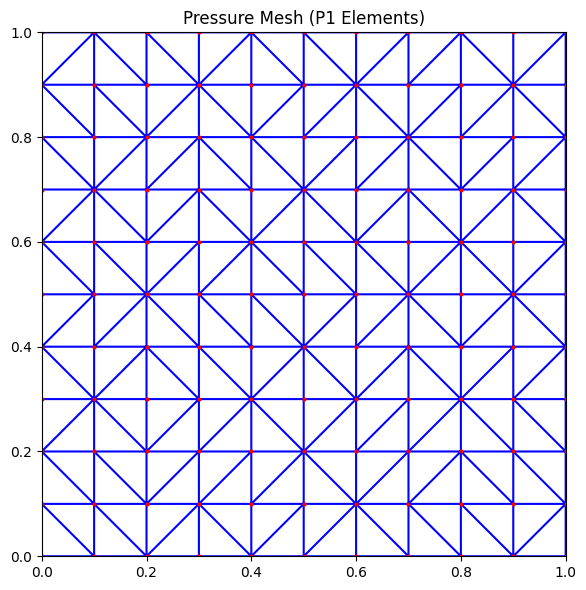

Mesh Summary (P1):
 - Number of nodes: 121
 - Number of triangles: 200
 - Domain: 1.00 x 1.00


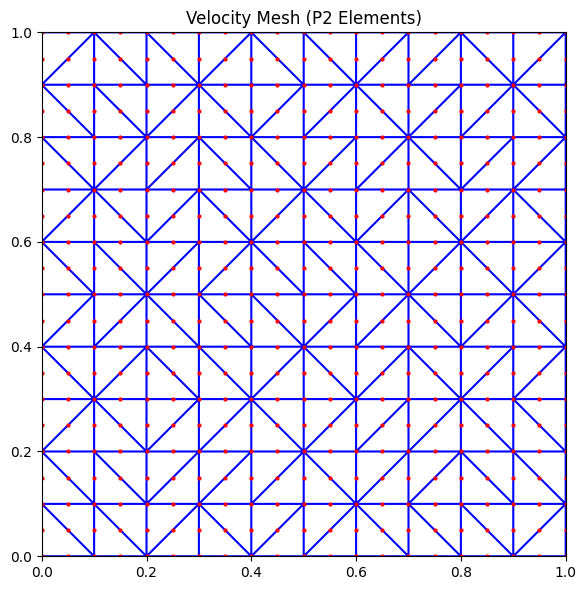

Mesh Summary (P2):
 - Number of nodes: 441
 - Number of triangles: 200
 - Domain: 1.00 x 1.00


In [3]:
# Generate unit square mesh
mesh = generate_triangular_mesh(x_len=1.0, y_len=1.0, mesh_size=0.1)
mesh['V2'], mesh['E2'] = generate_quadratic(mesh['points'], mesh['triangles'])

plot_mesh(mesh, element_order="P1")
plot_mesh(mesh, element_order="P2")

### Assemble global linear system

In [4]:
def assemble_stokes_system(mesh, kinematic_viscosity=1.0, element_type='P2P1'):
    """
    Assemble the finite element blocked system for the steady Stokes equations
    using either Taylor–Hood (P2-P1) or Equal-Order (P1-P1) elements.

    Inputs:
       mesh : dict containing mesh data ('points', 'triangles', 'V2', 'E2')
       kinematic_viscosity
       element_type : 'P2P1' (default) or 'P1P1'

    Returns:
       S : Global system matrix in CSR format.
       rhs : Right–hand side vector.
       dof_info : dictionary of degrees of freedom indices for velocity and pressure.
    """

    if element_type == 'P2P1':
        print("Using P2-P1 (Taylor-Hood) elements.")
        vel_points = mesh['V2']
        pres_points = mesh['points']
        elements_conn = mesh['E2']
        vel_nodes_per_elem = 6
        pres_nodes_per_elem = 3
        N_vel_nodes = vel_points.shape[0]
        N_pres_nodes = pres_points.shape[0]
        ndof_vel = 2 * N_vel_nodes
        ndof_pres = N_pres_nodes
        get_pres_nodes = lambda ei: elements_conn[ei, :3]
        get_vel_nodes = lambda ei: elements_conn[ei]
    else:  # P1P1
        print("Using P1-P1 (Equal Order) elements.")
        vel_points = mesh['points']
        pres_points = mesh['points']
        elements_conn = mesh['triangles']
        vel_nodes_per_elem = 3
        pres_nodes_per_elem = 3
        N_vel_nodes = vel_points.shape[0]
        N_pres_nodes = pres_points.shape[0]
        ndof_vel = 2 * N_vel_nodes
        ndof_pres = N_pres_nodes
        get_pres_nodes = lambda ei: elements_conn[ei]
        get_vel_nodes = lambda ei: elements_conn[ei]

    ndof = ndof_vel + ndof_pres

    rows_A, cols_A, vals_A = [], [], []
    rows_B, cols_B, vals_B = [], [], []

    # RHS vectors (zero for lid driven cavity)
    f_global = np.zeros(ndof_vel)
    g_global = np.zeros(ndof_pres)

    # Quadrature rule for triangles
    quad_pts_ref = np.array([
        [-0.10810301816807008, -0.78379396366385990], [-0.10810301816806966, -0.10810301816807061],
        [-0.78379396366386020, -0.10810301816806944], [-0.81684757298045740, -0.81684757298045920],
        [0.63369514596091700, -0.81684757298045810], [-0.81684757298045870, 0.63369514596091750]
    ])
    quad_w_ref = np.array([
        0.44676317935602256, 0.44676317935602256, 0.44676317935602256,
        0.21990348731064327, 0.21990348731064327, 0.21990348731064327
    ])
    xi_q = (quad_pts_ref[:, 0] + 1) / 2
    eta_q = (quad_pts_ref[:, 1] + 1) / 2
    w_q = quad_w_ref * 0.5

    ne = elements_conn.shape[0]
    for ei in range(ne):
        current_vel_nodes = get_vel_nodes(ei)
        current_pres_nodes = get_pres_nodes(ei)

        geom_node_indices = mesh['triangles'][ei]
        vertices = mesh['points'][geom_node_indices, :]
        x0, y0 = vertices[0, :]
        x1, y1 = vertices[1, :]
        x2, y2 = vertices[2, :]

        # Jacobian to convert to isoparametric element
        J = np.array([[x1 - x0, x2 - x0],
                      [y1 - y0, y2 - y0]])
        detJ = np.linalg.det(J)
        invJ = np.linalg.inv(J)

        A_loc = np.zeros((2 * vel_nodes_per_elem, 2 * vel_nodes_per_elem))
        B_loc = np.zeros((pres_nodes_per_elem, 2 * vel_nodes_per_elem))

        # Loop over quadrature points.
        for (xi, eta, w) in zip(xi_q, eta_q, w_q):
            if element_type == 'P2P1':
                N_basis_vel = np.array([(1 - xi - eta) * (1 - 2 * xi - 2 * eta), xi * (2 * xi - 1), eta * (2 * eta - 1),
                                        4 * xi * (1 - xi - eta), 4 * xi * eta, 4 * eta * (1 - xi - eta)])
                dN_dxi = np.array([-3 + 4 * xi + 4 * eta, 4 * xi - 1, 0, 4 - 8 * xi - 4 * eta, 4 * eta, -4 * eta])
                dN_deta = np.array([-3 + 4 * xi + 4 * eta, 0, 4 * eta - 1, -4 * xi, 4 * xi, 4 - 4 * xi - 8 * eta])
                grad_N_vel = np.zeros((vel_nodes_per_elem, 2))
                for i in range(vel_nodes_per_elem):
                    grad_N_vel[i, :] = invJ.T @ np.array([dN_dxi[i], dN_deta[i]])

                # Pressure: P1 basis functions evaluated at quad point
                phi_pres = np.array([1 - xi - eta, xi, eta])
            else:  # P1P1
                # Velocity & Pressure: P1 basis functions & gradients
                N_basis_vel = np.array([1 - xi - eta, xi, eta])
                phi_pres = N_basis_vel
                # P1 gradients on reference element
                dphi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
                grad_N_vel = (invJ.T @ dphi_ref.T).T

            weight = w * detJ

            # A_loc: Velocity stiffness matrix
            for i in range(vel_nodes_per_elem):
                for j in range(vel_nodes_per_elem):
                    grad_dot = np.dot(grad_N_vel[i], grad_N_vel[j])
                    # u-u block (indices 0 to Nv-1)
                    A_loc[i, j] += kinematic_viscosity * grad_dot * weight
                    # v-v block (indices Nv to 2*Nv-1)
                    A_loc[i + vel_nodes_per_elem, j + vel_nodes_per_elem] += kinematic_viscosity * grad_dot * weight

            # B_loc: velocity-pressure coupling
            for i in range(pres_nodes_per_elem):  # Pressure basis function index
                for j in range(vel_nodes_per_elem):  # Velocity basis function index
                    B_loc[i, j] += - phi_pres[i] * grad_N_vel[j, 0] * weight
                    B_loc[i, j + vel_nodes_per_elem] += - phi_pres[i] * grad_N_vel[j, 1] * weight


        for local_i in range(2 * vel_nodes_per_elem):
            node_idx_i = local_i % vel_nodes_per_elem
            global_node_i = current_vel_nodes[node_idx_i]

            if local_i < vel_nodes_per_elem:  # u-component
                gi = global_node_i
            else:  # v-component
                gi = global_node_i + N_vel_nodes

            for local_j in range(2 * vel_nodes_per_elem):
                node_idx_j = local_j % vel_nodes_per_elem
                global_node_j = current_vel_nodes[node_idx_j]

                if local_j < vel_nodes_per_elem:  # u-component
                    gj = global_node_j
                else:  # v-component
                    gj = global_node_j + N_vel_nodes

                if abs(A_loc[local_i, local_j]) > 1e-14:
                    rows_A.append(gi)
                    cols_A.append(gj)
                    vals_A.append(A_loc[local_i, local_j])

        for i in range(pres_nodes_per_elem):
            gi_p = current_pres_nodes[i]

            for local_j in range(2 * vel_nodes_per_elem):  # Local velocity DOF index
                node_idx_j = local_j % vel_nodes_per_elem
                global_node_j = current_vel_nodes[node_idx_j]

                if local_j < vel_nodes_per_elem:  # u-component global DoF index
                    gj = global_node_j
                else:  # v-component global DoF index
                    gj = global_node_j + N_vel_nodes

                if abs(B_loc[i, local_j]) > 1e-14:
                    rows_B.append(gi_p)
                    cols_B.append(gj)
                    vals_B.append(B_loc[i, local_j])

    A_global = csr_matrix((vals_A, (rows_A, cols_A)), shape=(ndof_vel, ndof_vel))
    B_global = csr_matrix((vals_B, (rows_B, cols_B)), shape=(ndof_pres, ndof_vel))
    BT_global = B_global.transpose()

    zero_pp = csr_matrix((ndof_pres, ndof_pres))

    # Assemble the final saddle-point system matrix S = [[A, -B^T], [B, 0]]
    S = bmat([[A_global, -BT_global],
              [B_global, zero_pp]], format='csr')

    rhs = np.concatenate([f_global, g_global])

    dof_info = {
        'vel': np.arange(ndof_vel),
        'pres': np.arange(ndof_vel, ndof),
        'u': np.arange(N_vel_nodes),
        'v': np.arange(N_vel_nodes, 2 * N_vel_nodes),
        'N_vel_nodes': N_vel_nodes,
        'N_pres_nodes': N_pres_nodes,
        'element_type': element_type
    }
    return S, rhs, dof_info

### Apply boundary conditions
#### Note: In the Stokes equations, only the gradient of the pressure field appears, meaning that pressure is determined up to an arbitrary additive constant. To obtain a unique solution, the pressure must be fixed at a single point. Here, the pressure at the bottom-left corner node is set to zero.


In [5]:
def apply_boundary_conditions(S, rhs, mesh, dof_info, vel_tol=1e-6):
    """
    Apply (Strong) Dirichlet boundary conditions for the lid-driven cavity problem
    to the Stokes system matrix and RHS vector.

    Inputs:
       S : Global saddle–point system matrix (must be in LIL format for efficiency).
       rhs : Right–hand side vector.
       mesh : Mesh dictionary.
       dof_info : Dictionary containing DoF information from assembler.
       vel_tol : Tolerance for identifying boundary nodes.

    Returns:
       S_bc : System matrix with BCs applied (CSR format).
       rhs_bc : RHS vector with BCs applied.
    """
    element_type = dof_info.get('element_type', 'P2P1')
    N_vel_nodes = dof_info['N_vel_nodes']

    if element_type == 'P2P1':
        vel_points = mesh['V2']
    else:  # P1P1
        vel_points = mesh['points']

    S_lil = S.tolil()
    rhs_bc = rhs.copy()

    x_len = mesh.get('x_len', 1.0)
    y_len = mesh.get('y_len', 1.0)
    boundary_vel_node_indices = []
    for i, (x, y) in enumerate(vel_points):
        is_on_boundary = (abs(x - 0) < vel_tol or abs(x - x_len) < vel_tol or
                          abs(y - 0) < vel_tol or abs(y - y_len) < vel_tol)
        if is_on_boundary:
            boundary_vel_node_indices.append(i)

    # Get global DOF indices for boundary velocity nodes
    boundary_dofs = []
    for node_idx in boundary_vel_node_indices:
        boundary_dofs.append(node_idx)  # u-component global DoF
        boundary_dofs.append(node_idx + N_vel_nodes)  # v-component global DoF
    boundary_dofs = np.unique(boundary_dofs)

    # Enforce u=1,v=0 on top lid (y=y_len), u=0,v=0 elsewhere
    for dof in boundary_dofs:
        node_index = dof % N_vel_nodes
        node_y_coord = vel_points[node_index, 1]

        prescribed_value = 0.0
        is_on_top_lid = abs(node_y_coord - y_len) < vel_tol
        is_u_component = dof < N_vel_nodes

        if is_on_top_lid and is_u_component:
            prescribed_value = 1.0

        S_lil[dof, :] = 0.0
        S_lil[dof, dof] = 1.0
        rhs_bc[dof] = prescribed_value

    # Fix one pressure DoF for uniqueness
    p_fix_dof = dof_info['pres'][0]
    S_lil[p_fix_dof, :] = 0.0
    S_lil[p_fix_dof, p_fix_dof] = 1.0
    rhs_bc[p_fix_dof] = 0.0

    return S_lil.tocsr(), rhs_bc

### Visualisation functions

In [6]:

def plot_field(points, triangles, field, field_label, title, cmap='viridis', percentile_clip=(1, 99)):
    """Plots a scalar field defined on mesh nodes using tricontourf."""
    fmin, fmax = np.percentile(field, percentile_clip)

    plt.figure(figsize=(8, 6))
    tri_obj = tri.Triangulation(points[:, 0], points[:, 1], triangles)

    contour_levels = np.linspace(fmin, fmax, 15)
    tpc = plt.tricontourf(tri_obj, field, levels=contour_levels, cmap=cmap, extend='both')

    plt.colorbar(tpc, label=field_label)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}_field.png", dpi=300)
    plt.show()


def plot_streamlines(points, u, v, title="Velocity Streamlines", density=1.5):
    """Plots velocity streamlines using interpolation onto a regular grid."""
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])

    num_interp_pts = 100
    xi = np.linspace(x_min, x_max, num_interp_pts)
    yi = np.linspace(y_min, y_max, num_interp_pts)
    Xg, Yg = np.meshgrid(xi, yi)

    Ug = griddata(points, u, (Xg, Yg), method='linear', fill_value=0)
    Vg = griddata(points, v, (Xg, Yg), method='linear', fill_value=0)

    plt.figure(figsize=(8, 6))
    magnitude = np.sqrt(Ug**2 + Vg**2)
    plt.streamplot(xi, yi, Ug, Vg, density=density, linewidth=0.8, color=magnitude, cmap='viridis')  #
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}_streamlines.png", dpi=300)
    plt.show()

### Plot and display results

In [7]:
kinematic_viscosity = 0.01

# Solve P2-P1 System
S_p2p1, rhs_p2p1, dof_info_p2p1 = assemble_stokes_system(mesh, kinematic_viscosity=kinematic_viscosity,
                                                         element_type='P2P1')
S_p2p1_bc, rhs_p2p1_bc = apply_boundary_conditions(S_p2p1, rhs_p2p1, mesh, dof_info_p2p1)
sol_p2p1 = spsolve(S_p2p1_bc, rhs_p2p1_bc)

# Extract P2-P1 components from solution array
N_vel_nodes_p2 = dof_info_p2p1['N_vel_nodes']
u_p2 = sol_p2p1[dof_info_p2p1['u']]
v_p2 = sol_p2p1[dof_info_p2p1['v']]
p_p2 = sol_p2p1[dof_info_p2p1['pres']]

Using P2-P1 (Taylor-Hood) elements.


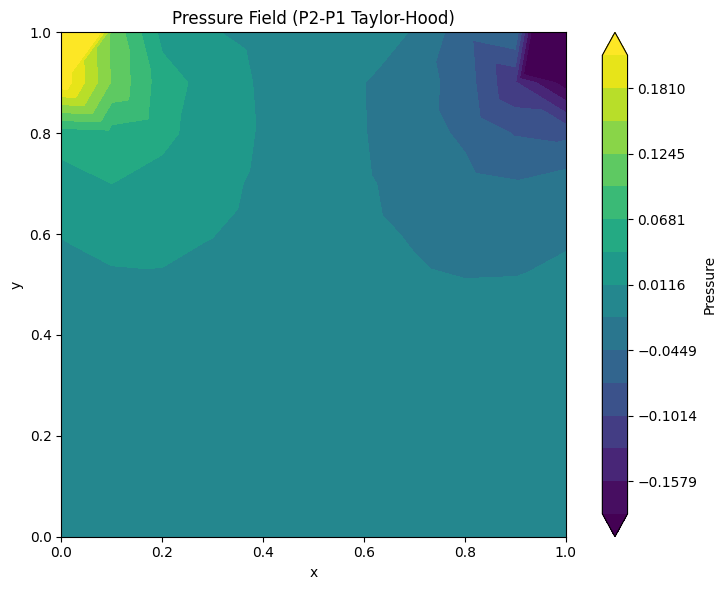

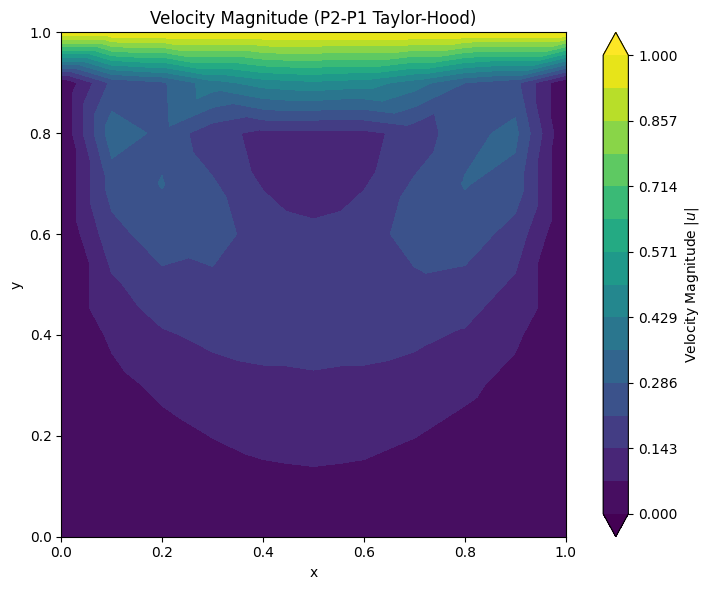

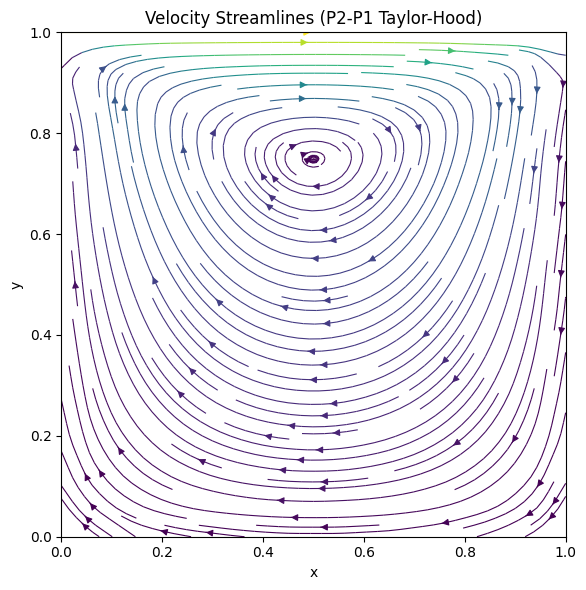

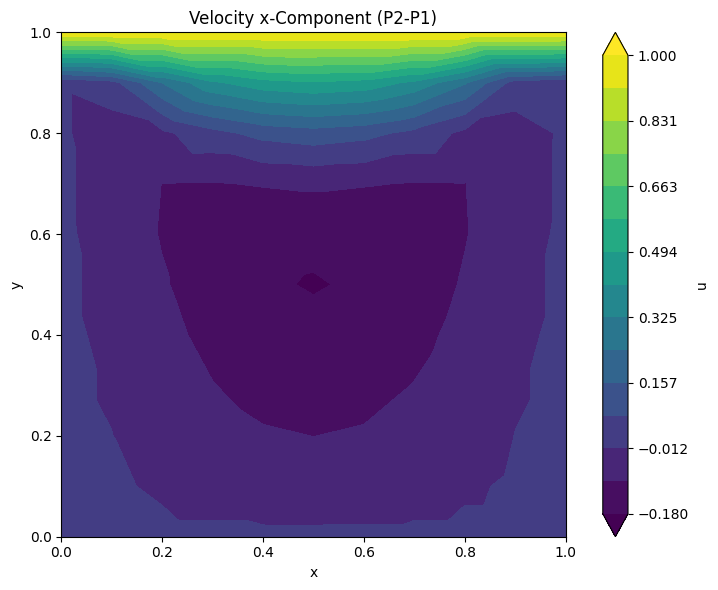

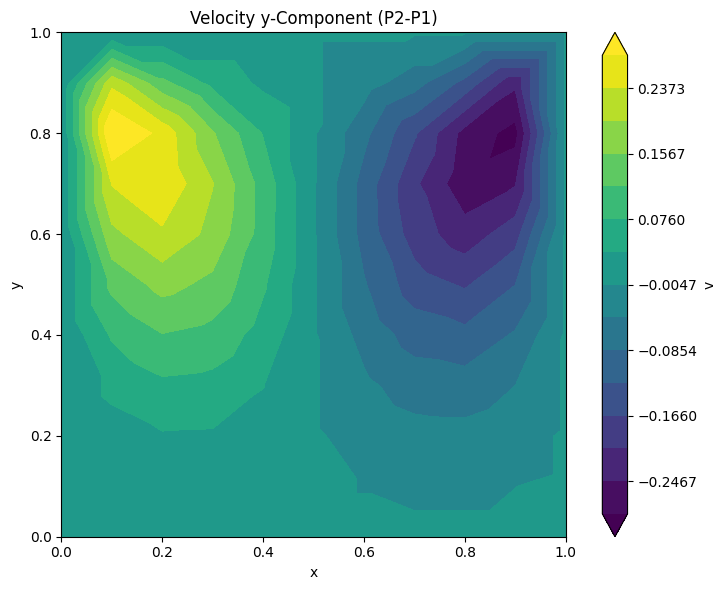

In [8]:
# Visualisation
plot_field(mesh['points'], mesh['triangles'], p_p2,
           field_label='Pressure',
           title='Pressure Field (P2-P1 Taylor-Hood)',
           percentile_clip=(1, 99))

vel_mag_p2 = np.sqrt(u_p2 ** 2 + v_p2 ** 2)
plot_field(mesh['V2'], mesh['E2'][:, :3], vel_mag_p2,
           field_label='Velocity Magnitude $|u|$',
           title='Velocity Magnitude (P2-P1 Taylor-Hood)')

plot_streamlines(mesh['V2'], u_p2, v_p2, title='Velocity Streamlines (P2-P1 Taylor-Hood)')

plot_field(mesh['V2'], mesh['E2'][:,:3], u_p2, field_label='u', title='Velocity x-Component (P2-P1)')
plot_field(mesh['V2'], mesh['E2'][:,:3], v_p2, field_label='v', title='Velocity y-Component (P2-P1)')

### Compare P2-P1 against P1-P1

In [9]:
# Solve the P1-P1 system
S_p1p1, rhs_p1p1, dof_info_p1p1 = assemble_stokes_system(mesh, kinematic_viscosity=kinematic_viscosity,
                                                         element_type='P1P1')
S_p1p1_bc, rhs_p1p1_bc = apply_boundary_conditions(S_p1p1, rhs_p1p1, mesh, dof_info_p1p1)

# Exception handling to see whether P1-P1 fails
try:
    sol_p1p1 = spsolve(S_p1p1_bc, rhs_p1p1_bc)

    # Extract P2-P1 components from solution array
    N_vel_nodes_p1 = dof_info_p1p1['N_vel_nodes']
    u_p1 = sol_p1p1[dof_info_p1p1['u']]
    v_p1 = sol_p1p1[dof_info_p1p1['v']]
    p_p1 = sol_p1p1[dof_info_p1p1['pres']]
except Exception as e:
    print(f"Error solving P1-P1 system: {e}")

Using P1-P1 (Equal Order) elements.
Error solving P1-P1 system: failed to factorize matrix at line 406 in file ../scipy/sparse/linalg/_dsolve/SuperLU/SRC/dpanel_bmod.c



In [10]:
# Compute condition number of each
def analyze_matrix_condition_number(S_bc, label):
    print(f"Analyzing {label} matrix...")

    # Compute smallest singular value
    svs_small = np.sort(svds(S_bc.tocsc(), k=1, which='SM', return_singular_vectors=False))
    sigma_min = svs_small[0]
    print(f"    Smallest singular value (σ_min) for {label}: {sigma_min:.4e}")

    # Compute largest singular value
    sigma_max_arr = svds(S_bc.tocsc(), k=1, which='LM', return_singular_vectors=False)
    sigma_max = sigma_max_arr[0]
    print(f"    Largest singular value  (σ_max) for {label}: {sigma_max:.4e}")

    # Estimate condition number
    condition_num = sigma_max / sigma_min
    print(f"    Estimated condition number (κ) for {label} matrix: {condition_num:.4e}")


analyze_matrix_condition_number(S_p2p1_bc, "P2-P1")
analyze_matrix_condition_number(S_p1p1_bc, "P1-P1")

Analyzing P2-P1 matrix...
    Smallest singular value (σ_min) for P2-P1: 1.6557e-04
    Largest singular value  (σ_max) for P2-P1: 1.0116e+00
    Estimated condition number (κ) for P2-P1 matrix: 6.1096e+03
Analyzing P1-P1 matrix...
    Smallest singular value (σ_min) for P1-P1: 7.7294e-14
    Largest singular value  (σ_max) for P1-P1: 1.0147e+00
    Estimated condition number (κ) for P1-P1 matrix: 1.3128e+13


## Summary, Discussion & Future Directions

This miniapp successfully demonstrated the critical importance of selecting appropriate finite element spaces for solving the incompressible Stokes equations.
Through the lid-driven flow experiment, it was identified that:

1.  **Taylor-Hood (P2-P1) Elements:** As predicted by the theory, this stable element pair produced a smooth, physically realistic pressure field and a well-defined velocity field (showing the expected primary vortex) for the lid-driven cavity benchmark. The resulting linear system was well-behaved, leading to a reliable solution. The condition number analysis typically shows a better-conditioned matrix compared to unstable elements.
2.  **Equal-Order (P1-P1) Elements:** This unstable pairing failed to satisfy the inf-sup condition, resulting in a failure for the linear system to be solved. The condition number analysis revealed a much poorer conditioning, reflecting the system's inherent instability.

**What Worked Well:**

* The modular structure of my code made testing different element types easy.
* The selected benchmark problem exhibits many different types of mechanics that could be good at interpreting nuances in a solver method.

**Areas for Improvement & Limitations:**

* The simple structured triangular mesh doesn't optimally resolve flow features, especially near the corners (singularities). Maybe this could be a contributing reason that the P1-P1 solver did not converge to a solution. Therefore, this could be classified as doubts in my result conclusions.

**Next Steps & Future Directions:**

This implementation serves as a foundation for exploring more complex fluid dynamics problems. Potential future directions include:

1.  **Navier-Stokes Equations:** Incorporate the non-linear convection term $(\mathbf{u} \cdot \nabla)\mathbf{u}$ to simulate flows at higher Reynolds numbers. This requires implementing a non-linear solver strategy.
2.  **Time-Dependent Simulation:** Extend the formulation to the unsteady Stokes equations using appropriate time-stepping schemes.
3.  **Alternative Elements/Stabilization:** An issue was that I could not really compare the results of two different element forumalations, as P1-P1 failed before I could retrieve results. I could either compare with the less optimal stable elements P2-P0 like in the textbook, or explore stabilized methods like SUPG-PSPG or VMS that allow the use of equal-order interpolations (Pk-Pk) by modifying the weak formulation. I chiefly use stabilized methods in my research code.